In [1]:
import os
import gc
import string
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import re
import requests
from datetime import datetime as dt, timedelta, date, time
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
import joblib
import spacy
from nltk.util import ngrams
import multiprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, plot_precision_recall_curve
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans

In [2]:
def get_stock_data():
    pass

def update_stock_data():
    pass

In [3]:
def load_stock_data(ticker='TSLA'):
    '''Load csv file to a pandas dataframe.
    
    Args:
        symbol: company's symbol
        
    Returns:
        A pandas dataframe containing the stock's data.
    '''
    
    df = pd.read_csv(f'data/{ticker}.csv')
    df.columns = ['date', 'close', 'open', 'high', 'low', 'volume', 'pct_change']
    
    return df

In [4]:
def clean_stock_data(df):
    '''Clean dataframe: change variables to appropriate dtypes.
    
    Args:
        df: pandas dataframe
        
    Returns:
        A cleaned dataframe ready to be modeled.
    '''
    
    df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y')
    
    cols_num = ['close', 'open', 'high', 'low']
    df[cols_num] = df[cols_num].astype(float)
    
    df['volume'] = df['volume'].str.replace('.', '').str.replace('M', '000000')
    df['volume'] = df['volume'].str.replace('.', '').str.replace('K', '000')
    df['volume'] = df['volume'].astype(int)
    
    df['pct_change'] = df['pct_change'].str.rstrip('%')
    df['pct_change'] = df['pct_change'].astype(float) / 100
    
    return df

In [5]:
def scraper(url):
    '''Scrape news data on stocks from a given url.
    
    Args:
        url: a string containing the news' url
        
    Returns:
        datetime: a datetime object containing date and time when news was released to the public
        text: the contents of the news
    '''
    
    page = requests.get(url, headers={'User-Agent': 'Chrome/79.0.3945.130'})
    soup = BeautifulSoup(page.content, 'html.parser')
    
    content_section = soup.find('div', {'class': 'contentSectionDetails'})
    datetime = dt.strptime(re.search(r'(\w{3} \d{2}, \d{4} \d{2}:\d{2}\w{2})',
                                     content_section.find('span').text).group(),
                           '%b %d, %Y %I:%M%p')
    
    text_section = soup.find('div', {'class': 'WYSIWYG articlePage'}).find_all('p')
    text = ' '.join([text_section[i].text for i in range(1, len(text_section))])
    
    return datetime, text

In [6]:
def get_news_data(page):
    '''Get news on stocks from the page in Investing.com website.
    
    Args:
        page: the page from which the news will be extracted
    
    Returns:
        A pandas dataframe for the page containing datetime, title and contents from the news.
    '''
    
    url_investing = 'https://investing.com'
    title_ls = []
    dt_ls = []
    text_ls = []
    url = f'/equities/tesla-motors-news/{page}'
    result = requests.get(url_investing + url,
                          headers={'User-Agent': 'Chrome/79.0.3945.130'})
    soup = BeautifulSoup(result.content, 'html.parser')

    anchors_ls = [art.find('a') for art in soup.find_all('article')]
    for a in anchors_ls:
        if a['href'].startswith('/news'):
            title_ls.append(a.find('img').get('alt'))
            url_contents = scraper(url_investing + a['href'])
            dt_ls.append(url_contents[0])
            text_ls.append(url_contents[1])

    news_data = {'datetime': dt_ls, 'title': title_ls, 'text': text_ls}
    news_df = pd.DataFrame(news_data)
    
    joblib.dump(news_df, f'data/news tesla/news_df{page}.pkl')
    
    return news_df

In [7]:
def save_news_df(initial_pg, final_pg):
    '''Parallelizes the extraction of news data using the get_news_data function.
    
    Args:
        initial_pg: initial page
        final_pg: final page (not inclusive)
    
    Returns:
        A pandas dataframe containing all the news from 2016 until today.
    '''
    
    pool = multiprocessing.Pool()
    df_ls = pool.map(get_news_data, range(initial_pg, final_pg))
    pool.terminate()
    pool.join()
    
    news_df = (pd.concat(df_ls, axis=0)
               .drop_duplicates()
               .sort_values('datetime', ascending=False)
               .reset_index(drop=True))
    
    joblib.dump(news_df, 'data/news_tesla_df.pkl')

In [8]:
def load_news_df():
    news_df = pd.DataFrame(columns=['datetime', 'title', 'text'])
    for i in range(7, 384):
        news_df = pd.concat([news_df, joblib.load(f'data/news tesla/news_df{i}.pkl')])
        
    return news_df.drop_duplicates().sort_values('datetime', ascending=False).reset_index(drop=True)

In [9]:
def clean_news_df(df):
    '''Clean and aggregate news by date. Given a date, only news realeased before market closure are aggregated.
    
    Args:
        df: pandas dataframe containing all the news ordered by datetime
        
    Returns:
        A pandas dataframe with all the news aggregated by date.
    '''
    
    # we want to work with news starting in 2015
    df = (df[(df['datetime'] <= dt(2020, 2, 3, 16)) & (df['datetime'] >= dt(2015, 1, 2))]
          .reset_index(drop=True))
    
    start = date(2015, 1, 1)
    end = date(2020, 2, 3)
    date_span = [end - timedelta(days=d) for d in range(0, (end - start).days)]

    date_ls = []
    news_ls = []
    for d in date_span:
        date_ls.append(d)

        window = ((df['datetime'] < dt.combine(d, time(16))) &\
                  (df['datetime'] >= dt.combine(d - timedelta(days=1), time(16))))
        news_ls.append(list(df.loc[window, 'text'].values))

    agg_news = {'date': date_ls, 'news': news_ls}
    agg_news_df = pd.DataFrame(agg_news)
    agg_news_df['date'] = pd.to_datetime(agg_news_df['date'], infer_datetime_format=True)
    
    return agg_news_df

In [10]:
tsla_df = clean_stock_data(load_stock_data())
agg_news_df = clean_news_df(load_news_df())
full_df = tsla_df.merge(agg_news_df, on='date').sort_values('date').reset_index(drop=True)

In [11]:
full_df['bullish'] = 0
full_df['bullish'] = (full_df['close'] > full_df['open']).astype(int)

In [12]:
cols_to_drop = ['date', 'close', 'open', 'high', 'low', 'volume', 'pct_change', 'bullish']
X = full_df.drop(cols_to_drop, axis=1)
y = full_df['bullish']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
def append_ngrams(tokens_ls):
    bigrams_ls = [' '.join(bigram) for bigram in list(ngrams(tokens_ls, 2))]
    trigrams_ls = [' '.join(trigram) for trigram in list(ngrams(tokens_ls, 3))]
    return tokens_ls + bigrams_ls + trigrams_ls

In [15]:
def clean_tokens(tokens_ls):
    bad_token = [' ', '  ', '\n', ' \n', '  \n']
    return [token for token in tokens_ls if token not in bad_token]

In [16]:
def news_tokenizer(df):
    tokens = []
    for news_ls in tqdm(df['news']):
        news_tokens = []
        for news in news_ls:
            doc = nlp(news)
            for sent in doc.sents:
                sent_tokens = [token.lemma_ for token in sent if not (token.is_stop or token.is_punct)]
#                 sent_tokens_ext = append_ngrams(clean_tokens(sent_tokens))
#                 news_tokens += sent_tokens_ext
                sent_tokens = clean_tokens(sent_tokens)
                news_tokens += sent_tokens
        tokens.append(news_tokens)
        
    df['tokens'] = tokens
    
    return df

In [17]:
def count_words(df, w):
    count = {w: []}
    for i in range(len(df)):
        count[w].append(df.loc[i, 'tokens'].count(w))
    return count

In [18]:
def get_bow(df):
    bow = set()
    for tokens_ls in df['tokens']:
        bow = bow.union(set(tokens_ls))
    return list(bow)

In [19]:
bow = get_bow(news_tokenizer(X_train))

100%|██████████| 1024/1024 [01:38<00:00, 10.42it/s]
/home/jeffc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
def count_matrix(df):
    pool = multiprocessing.Pool()
    func = partial(count_words, df)
    word_counts = pool.map(func, bow)
    pool.terminate()
    pool.join()
    
    count_dict = {list(wc.keys())[0]:  pd.arrays.SparseArray(list(wc.values())[0]) for wc in word_counts}
    
    return pd.DataFrame(count_dict)

In [22]:
tokens_transformer = FunctionTransformer(news_tokenizer)
cmat_transformer = FunctionTransformer(count_matrix)

sub_pipe = Pipeline([('tokenizer', tokens_transformer),
                     ('count_mat', cmat_transformer),
                     ('tfidf', TfidfTransformer()),
                     ('tsvd', TruncatedSVD(n_components=508))])

X_train_transf = sub_pipe.fit_transform(X_train)
X_test_transf = sub_pipe.transform(X_test)

100%|██████████| 1024/1024 [01:36<00:00, 10.59it/s]
/home/jeffc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
100%|██████████| 257/257 [00:43<00:00,  5.96it/s]
/home/jeffc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


explained variance ratio using 508 components: 90.2144%


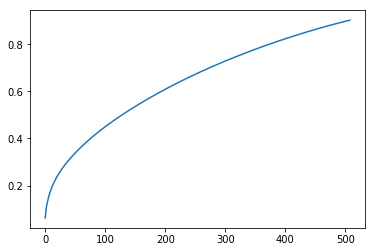

In [25]:
idx = range(508)
var_exp = np.cumsum(sub_pipe.named_steps['tsvd'].explained_variance_ratio_)
print('explained variance ratio using 508 components: {:.3f}%'.format(100 * var_exp[-1]))
plt.plot(idx, var_exp);

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
logr_clf = LogisticRegression(random_state=42, n_jobs=-1)

logr_params = {'penalty': ['l1', 'l2', 'elasticnet'],
               'C': ss.uniform(0, 1),
               'l1_ratio': ss.uniform(0, 1)}

In [29]:
svm_clf = SVC(probability=True, random_state=42)

svm_params = {'C': ss.uniform(0, 1),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [1, 2],
              'coef0': ss.uniform(-10, 10)}

In [30]:
lgbm_clf = LGBMClassifier(max_depth=1, random_state=42, n_jobs=-1)

lgbm_params = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'learning_rate': ss.uniform(0, 1),
               'n_estimators': range(1,500),
               'subsample': ss.uniform(0.001, 1),
               'subsample_freq': range(1,101),
               'colsample_bytree': ss.uniform(0.001, 1),
               'reg_alpha': ss.uniform(0, 1),
               'reg_lambda': ss.uniform(0, 1)}

In [31]:
xgb_clf = XGBClassifier(max_depth=1, random_state=42, n_jobs=-1)

xgb_params = {'learning_rate': ss.uniform(0, 1),
              'boster': ['gbtree', 'gblinear', 'dart'],
              'subsample': ss.uniform(0.001, 1),
              'colsample_bytree': ss.uniform(0.001, 1),
              'colsample_bylevel': ss.uniform(0.001, 1),
              'colsample_bynode': ss.uniform(0.001, 1),
              'reg_alpha': ss.uniform(0, 1),
              'reg_lambda': ss.uniform(0, 1),
              'num_parallel_tree': range(1,500)}

In [32]:
models = {'logr': [logr_clf, logr_params],
          'svm': [svm_clf, svm_params],
          'lgbm': [lgbm_clf, lgbm_params],
          'xgb': [xgb_clf, xgb_params]}

In [33]:
best_estimators = {}
for m in tqdm(models.keys()):
    rscv = RandomizedSearchCV(models[m][0],
                              models[m][1],
                              n_iter=500,
                              scoring='precision',
                              n_jobs=-1,
                              cv=tscv,
                              verbose=True,
                              random_state=42)

    rscv.fit(X_train_transf, y_train)
    best_estimators[m] = rscv.best_estimator_

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   34.3s finished
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
 25%|██▌       | 1/4 [00:36<01:49, 36.40s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 11.7min finished
 50%|█████     | 2/4 [12:23<07:55, 237.59s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  4.0min finished
 75%|███████▌  | 3/4 [16:20<03:57, 237.52s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 70.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 112.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 145.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 150.7min finished
100%|██████████| 4/4 [2:47:11<00:00, 2507.88s/it]


In [34]:
precision_scores = {}
precision_scores['train precision'] = []
precision_scores['val precision'] = []
precision_scores['test precision'] = []

for m in best_estimators.keys(): 
    best = best_estimators[m]
    results = cross_validate(best,
                             X_train_transf,
                             y_train,
                             cv=tscv,
                             scoring='precision',
                             return_train_score=True)

    train_score = results['train_score'].mean()
    val_score = results['test_score'].mean()
    test_score = cross_val_score(best,
                                 X_test_transf,
                                 y_test,
                                 cv=tscv,
                                 scoring='precision',
                                 n_jobs=-1).mean()

    precision_scores['train precision'].append(round(100 * train_score, 4))
    precision_scores['val precision'].append(round(100 * val_score, 4))
    precision_scores['test precision'].append(round(100 * test_score, 4))

/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio para

In [35]:
precision_scores_df = pd.DataFrame(precision_scores, index=list(best_estimators.keys()))
precision_scores_df

,train precision,val precision,test precision
logr,68.4679,59.1997,53.5693
svm,65.7861,63.7884,59.0849
lgbm,68.7192,58.3176,43.6948
xgb,72.6617,64.4202,54.6662


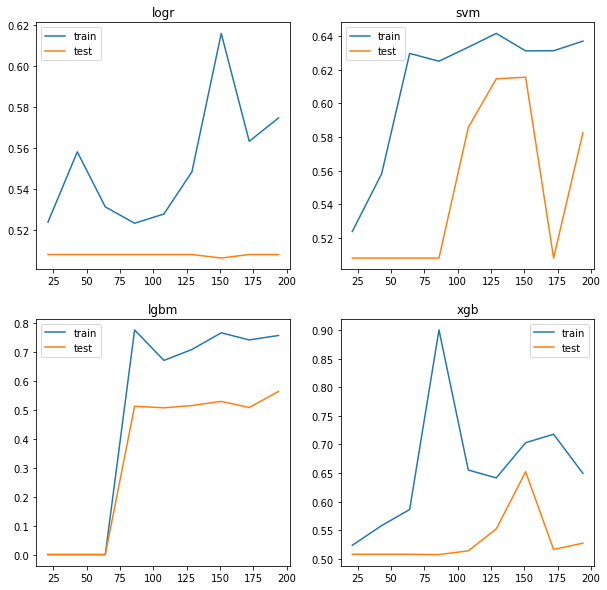

In [36]:
X_transf = np.concatenate((X_train_transf, X_test_transf), axis=0)
y = y_train.append(y_test).reset_index(drop=True)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i, m in enumerate(best_estimators.keys()):
    train_sizes, train_scores, test_scores = learning_curve(best_estimators[m],
                                                            X_transf,
                                                            y,
                                                            train_sizes=np.linspace(0.1, 0.9, 9),
                                                            cv=tscv,
                                                            scoring='precision',
                                                            n_jobs=-1)

    sns.lineplot(train_sizes, train_scores.mean(axis=1), markers=True, ax=axes[i]).set_title(m)
    sns.lineplot(train_sizes, test_scores.mean(axis=1), markers=True, ax=axes[i])
    axes[i].legend(['train', 'test']);

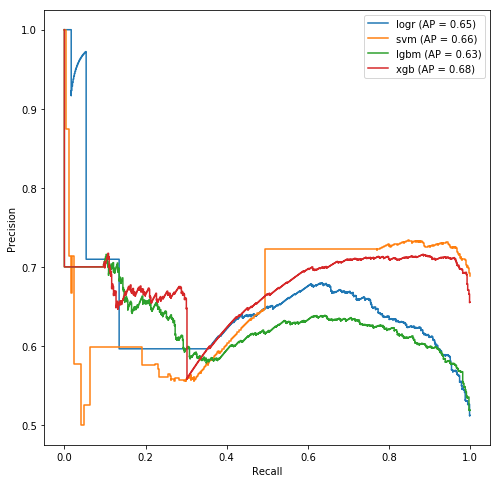

In [47]:
fig, ax = plt.subplots(figsize=(8,8))
for m in best_estimators.keys():
    plot_precision_recall_curve(best_estimators[m], X_transf, y, name=m, ax=ax)
    plt.legend(loc='upper right')

In [2]:
sub_pipe2 = Pipeline([('tokenizer', tokens_transformer),
                      ('count_mat', cmat_transformer),
                      ('tfidf', TfidfTransformer()),
                      ('tsvd', TruncatedSVD())])

X_transf = sub_pipe.fit_transform(X)

NameError: name 'tokens_transformer' is not defined